In [1]:
import dlib
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read points from text file
def readPoints(path) :
    # Create an array of points.
    points = [];
    
    # Read points
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(x), int(y)))
    return points

In [3]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), 
                         None, flags=cv2.INTER_LINEAR, 
                         borderMode=cv2.BORDER_REFLECT_101)

    return dst

In [4]:
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

In [5]:
#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
#             if len(ind) == 3:                                                
            delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri

In [6]:
# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
#     print(r1, r2)
    
    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

#     print(t2RectInt)
    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 

In [23]:

# Make sure OpenCV is version 3.0 or above
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver) < 3 :
    print >> sys.stderr, 'ERROR: Script needs OpenCV 3.0 or higher'
    sys.exit(1)

# Read images
filename1 = 'obama.jpg'
filename2 = 'donald_trump.jpg'

img1 = cv2.imread(filename1);
img2 = cv2.imread(filename2);
img1Warped = np.copy(img2);    

# Read array of corresponding points
points1 = readPoints(filename1 + '.txt')
points2 = readPoints(filename2 + '.txt')    

# Find convex hull
hull1 = []
hull2 = []

In [24]:
# hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)
hullIndex = np.array([x for x in range(68)])

In [25]:
for i in range(0, len(hullIndex)):
    hull1.append(points1[int(hullIndex[i])])
    hull2.append(points2[int(hullIndex[i])])

In [26]:
# Find delanauy traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = calculateDelaunayTriangles(rect, hull2)

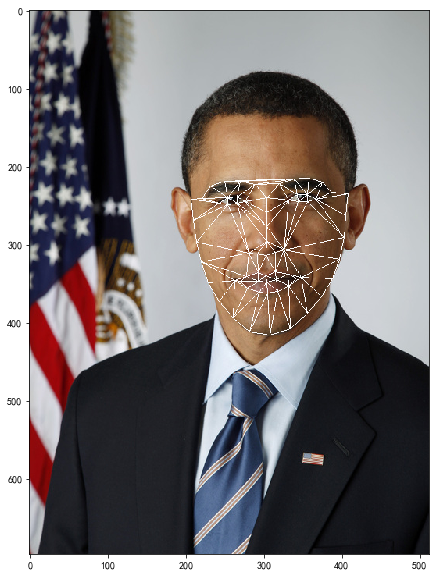

In [27]:
imgc = img1.copy()
for tri in dt:
    trs = [points1[x] for x in tri]
    trs.append(trs[0])
    for i in range(3):
        cv2.line(imgc, trs[i], trs[i+1], color=(255,255,255))
plt.figure(figsize=(12, 10))
plt.imshow(imgc[:,:,::-1])

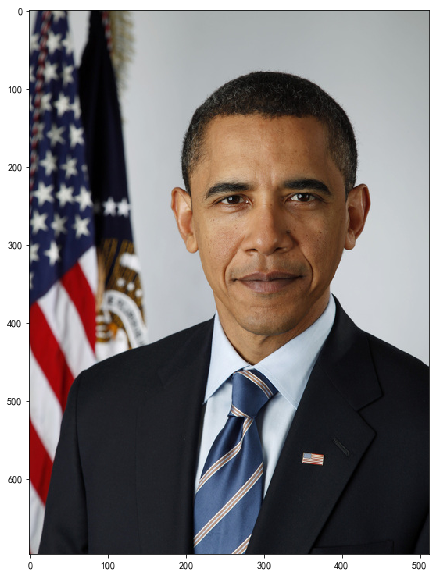

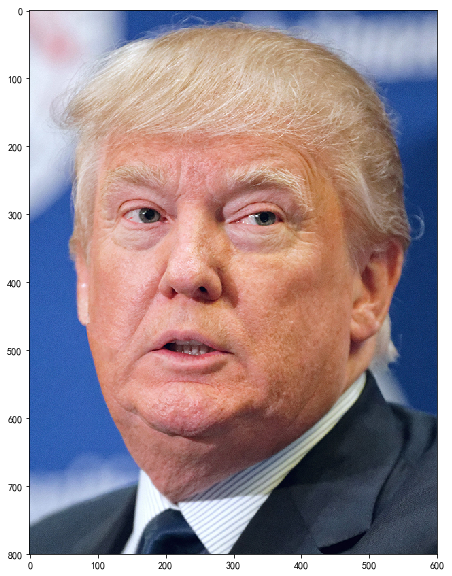

In [28]:
# Apply affine transformation to Delaunay triangles
img1_cp = img1.copy()
img2_cp = img2.copy()
tx = []
ty = []
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(hull1[dt[i][j]])
        t2.append(hull2[dt[i][j]])
    warpTriangle(img1, img1Warped, t1, t2)
    
plt.figure(figsize=(12, 10))
plt.imshow(img1_cp[:,:,::-1])
plt.figure(figsize=(12, 10))
plt.imshow(img2_cp[:,:,::-1])

In [29]:
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype = img2.dtype)  

In [30]:
for i in range(0, len(dt)):
    #get points for img1, img2 corresponding to the triangles
    tm = []
    for j in range(0, 3):
        tm.append(hull2[dt[i][j]])
    tm = np.array([tm])
    mask = cv2.fillConvexPoly(mask, tm, (255, 255, 255))

In [31]:
tm

array([[[228, 491],
        [244, 491],
        [228, 507]]])

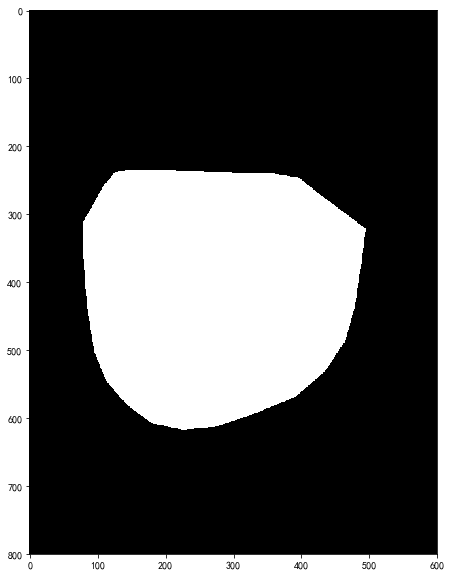

In [32]:
plt.figure(figsize=(12, 10))
plt.imshow(mask[:,:,::-1])

In [33]:
# cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

r = cv2.boundingRect(np.float32([hull2]))    

center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))


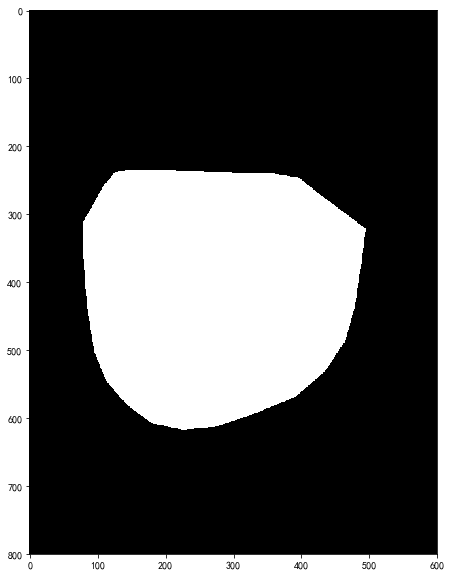

In [34]:
plt.figure(figsize=(12, 10))
plt.imshow(mask[:,:,::-1])

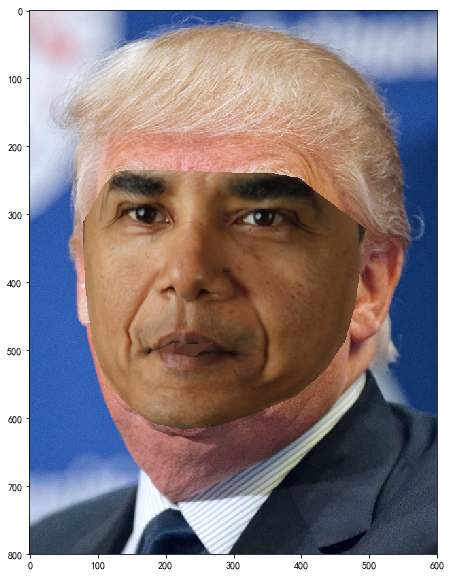

In [35]:
plt.figure(figsize=(12, 10))
plt.imshow(img1Warped[:,:,::-1])

In [36]:
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

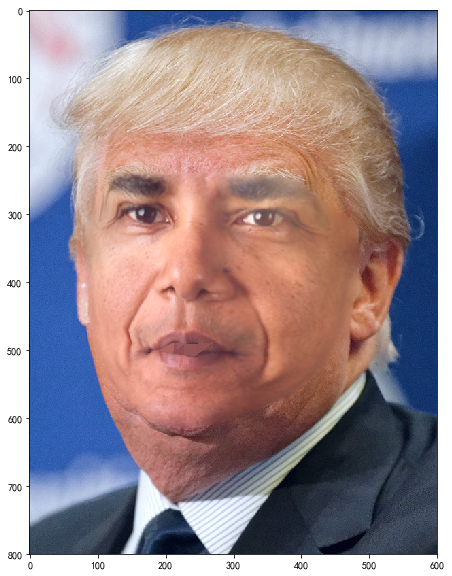

In [37]:
plt.figure(figsize=(12, 10))
plt.imshow(output[:,:,::-1])